# Zones
<div>
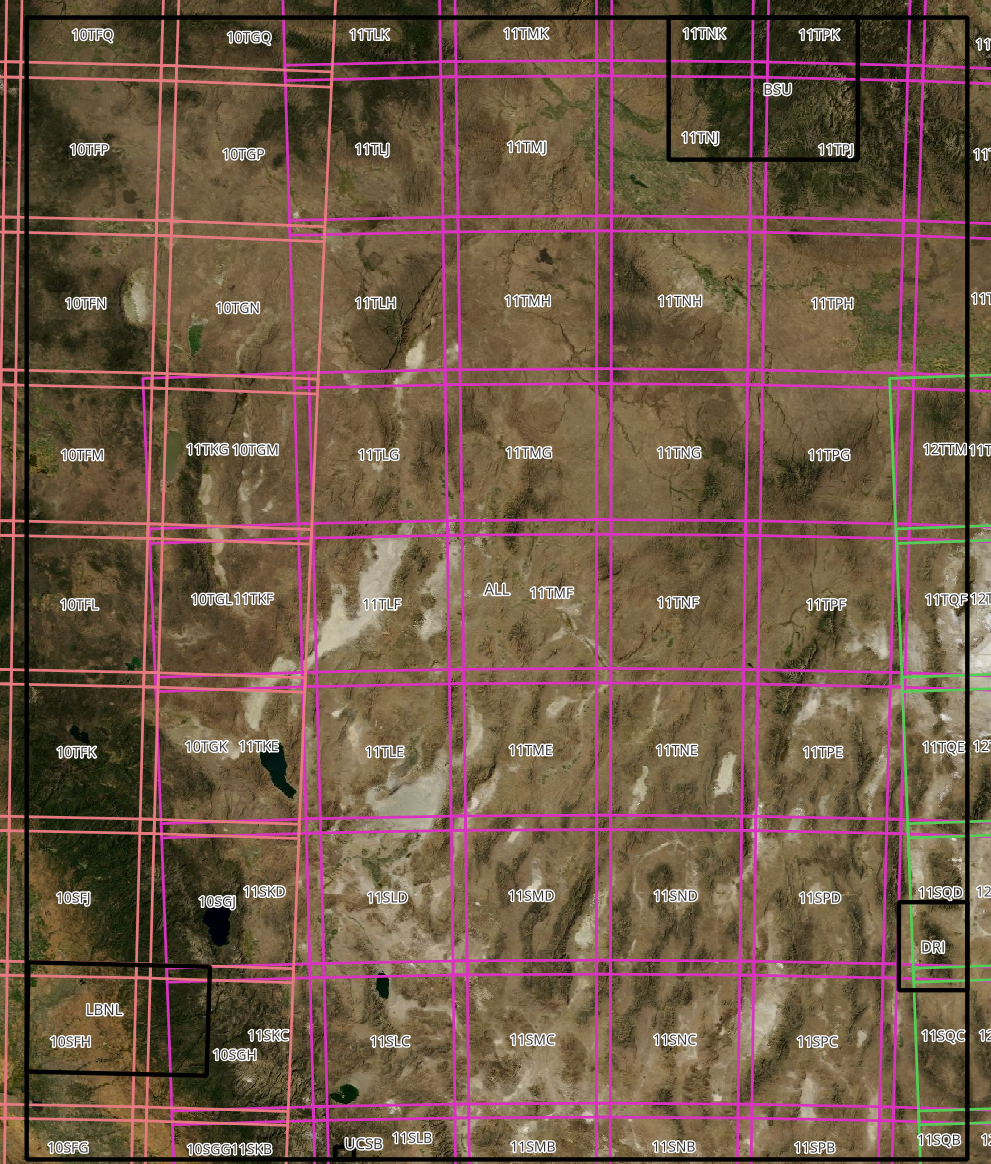
</div>
 

## UCSB
- Zone 11
- Tiles: 11SLB

## LBNL
- Zone 10
- Tiles: **10SFH, 10SGH**, (10SFJ, 10SGJ, 11SKD, 11SKC)
  
## DRI
- Zone 11
- Tiles: **11SQD, 11SQC**, (12STJ, 12STH)

## BSU
- Zone 11
- Tiles: **11TNK, 11TNJ, 11TPK, 11TPJ**

- Coordinates are pixel centers

In [ ]:
import geopandas
import pandas
import zarr
import xarray
import numpy as np
import dask
import dask.distributed
import pyproj
import matplotlib.pyplot as plt

In [ ]:
region = 'LBNL'

if region == 'UCSB':
    tiles = ['11SLB']
elif region == 'DRI':
    tiles =  ['11SQD', '11SQC']
elif region == 'LBNL':
    tiles = ['10SFH', '10SGH']
elif region == 'BSU':
    tiles = ['11TNK', '11TNJ', '11TPK', '11TPJ']

1. read in all tiles
1. rechunk band
1. combine

# Read tiles

In [ ]:
dss10 = {}
dss20 = {}
for tile in tiles:
    zarr_store_10m = f'/data/sentinel2/zarrs_v3/{tile}_10m.zarr'    
    zarr_store_20m = f'/data/sentinel2/zarrs_v3/{tile}_20m.zarr'    
    ds10 = xarray.open_zarr(zarr_store_10m, consolidated=False)
    ds20 = xarray.open_zarr(zarr_store_20m, consolidated=False)
    dss10[tile] = ds10
    dss20[tile] = ds20

# Subsetting to ROI

In [ ]:
crs_string= dss10[tiles[0]]['spatial_ref'].projected_crs_name
crs = pyproj.CRS(crs_string)
epsg = crs.to_epsg()

In [ ]:
# ROIs from the tristate project
path = '/data/shapes/tristate_rois.gpkg'
rois = geopandas.read_file(path)

bounds = rois[rois['name'] == region].to_crs(epsg).buffer(50).iloc[0].bounds
minx, miny, maxx, maxy = bounds

In [ ]:
for tile in tiles:   
    dss10[tile] = dss10[tile].sel(x=slice(minx, maxx), y=slice(maxy, miny),
                                  x_angles=slice(minx-2500, maxx+2500), y_angles=slice(maxy+2500, miny-2500))

    dss20[tile] = dss20[tile].sel(x=slice(minx, maxx), y=slice(maxy, miny),
                                  x_angles=slice(minx-2500, maxx+2500), y_angles=slice(maxy+2500, miny-2500))

# Dealing with detectors
... since the tiles are generated by the same overpass, the same tile will always be observed by the same detectors, which may be differing from the detectors observing the neighboring tiles

In [ ]:
detectors10 = set()
detectors20 = set()
for tile in tiles:
    detectors10 = detectors10.union(set(dss10[tile].detector.to_numpy()))
    detectors20 = detectors20.union(set(dss20[tile].detector.to_numpy()))

detectors10 = sorted(list(detectors10))
detectors20 = sorted(list(detectors20))

In [ ]:
for tile in tiles:
    dss10[tile] = dss10[tile].reindex(detector=detectors10)
    dss20[tile] = dss20[tile].reindex(detector=detectors20)

# Unify Times across tiles
1. find intersection of timesteps that exist in all tiles
1. cut to intersection

In [ ]:
# Set to timesteps of first 10m tile
rounded = '5d'
times = set(dss10[tiles[0]].time.dt.round(rounded).values)

# Make intersection with all other 10m tiles
for tile, ds in dss10.items():
    times = times.intersection(ds.time.dt.round(rounded).values)    

# Make intersection with all 20m tiles
for tile, ds in dss20.items():
    times = times.intersection(ds.time.dt.round(rounded).values)    

# Those are timesteps available in all tiles 
times = sorted(np.array(list(times)))
len(times)

In [ ]:
for tile in tiles:
    dss10[tile] = dss10[tile].sel(time=times, method='nearest')    
    dss20[tile] = dss20[tile].sel(time=times, method='nearest')    

In [ ]:
for tile in tiles:
    dss10[tile]['time_actual'] = dss10[tile]['time']
    dss20[tile]['time_actual'] = dss20[tile]['time']
    dss10[tile]['time'] = dss10[tile].time.dt.round(rounded)
    dss20[tile]['time'] = dss20[tile].time.dt.round(rounded)

# BSU

In [ ]:
top_left = '11TNK'
top_right = '11TPK'
bottom_left = '11TNJ'
bottom_right = '11TPJ'

In [ ]:
# Cut left-right first

x_split = dss10[top_left].x.max()+10
dss10[top_right] = dss10[top_right].sel(x=slice(x_split, None))
dss20[top_right] = dss20[top_right].sel(x=slice(x_split, None))
dss10[bottom_right] = dss10[bottom_right].sel(x=slice(x_split, None))
dss20[bottom_right] = dss20[bottom_right].sel(x=slice(x_split, None))

x_angles_split = dss10[top_left].x.max()
dss10[top_right] = dss10[top_right].sel(x_angles=slice(x_angles_split, None))
dss20[top_right] = dss20[top_right].sel(x_angles=slice(x_angles_split, None))
dss10[bottom_right] = dss10[bottom_right].sel(x_angles=slice(x_angles_split, None))
dss20[bottom_right] = dss20[bottom_right].sel(x_angles=slice(x_angles_split, None))

y_split = dss10[top_left].y.min()-10
dss10[bottom_left] = dss10[bottom_left].sel(y=slice(y_split, None))
dss20[bottom_left] = dss20[bottom_left].sel(y=slice(y_split, None))
dss10[bottom_right] = dss10[bottom_right].sel(y=slice(y_split, None))
dss20[bottom_right] = dss20[bottom_right].sel(y=slice(y_split, None))

y_angles_split = dss10[top_left].y_angles.min()
dss10[bottom_left] = dss10[bottom_left].sel(y_angles=slice(y_angles_split, None))
dss20[bottom_left] = dss20[bottom_left].sel(y_angles=slice(y_angles_split, None))
dss10[bottom_right] = dss10[bottom_right].sel(y_angles=slice(y_angles_split, None))
dss20[bottom_right] = dss20[bottom_right].sel(y_angles=slice(y_angles_split, None))

# DRI
slicing in Y is confusing since the coordinates run backwards (from highest to lowest)

In [ ]:
top = '11SQD'
bottom = '11SQC'

y_split = dss10[top].y.min()-10
y_angles_split = dss10[top].y_angles.min()

dss10[bottom] = dss10[bottom].sel(y=slice(y_split, None))
dss20[bottom] = dss20[bottom].sel(y=slice(y_split, None))

dss10[bottom] = dss10[bottom].sel(y_angles=slice(y_angles_split, None))
dss20[bottom] = dss20[bottom].sel(y_angles=slice(y_angles_split, None))

# LBNL

In [ ]:
left = '10SFH'
right = '10SGH'

x_split = dss10[left].x.max()+10
dss10[right] = dss10[right].sel(x=slice(x_split, None))
dss20[right] = dss20[right].sel(x=slice(x_split, None))

xangles_split = dss10[left].x_angles.max()
dss10[right] = dss10[right].sel(x_angles=slice(xangles_split, None))
dss20[right] = dss20[right].sel(x_angles=slice(xangles_split, None))

# UCSB

In [ ]:
combined10 = dss10['11SLB']
combined20 = dss20['11SLB']

# Combine the DS
Multiple options here:
- `xarray.combine_by_coords([ds1, ds2], combine_attrs='drop')` seems like the correct tool. But we have to split x/yangles coordinates.
- `ds1.combine_first(ds2)`. Struggle with the chunk size and may bloat memory. But the good part is that we don't need to slice the overlapping coordinates
- `xarray.concat([ds1, ds2], dim=('x'))`. Also requires to split x/yangles. Also will create arificial coordinates

In [ ]:
xy10 = ['AOT', 'WVP', 'reflectance']
xy20 = ['CLD', 'SCL', 'SNW', 'WVP', 'reflectance']
angles = ['sun_azimuth_grid', 'sun_zenith_grid', 'viewing_azimuth_grid', 'viewing_zenith_grid']

In [ ]:
combined10_1 = xarray.combine_by_coords([ds[xy10] for ds in dss10.values()], combine_attrs='override', join='outer')
combined10_2 = xarray.combine_by_coords([ds[angles] for ds in dss10.values()], combine_attrs='override', join='outer')
combined10 = xarray.merge([combined10_1, combined10_2, dss10[tiles[0]]['spatial_ref']])

combined20_1 = xarray.combine_by_coords([ds[xy20] for ds in dss20.values()], combine_attrs='override', join='outer')
combined20_2 = xarray.combine_by_coords([ds[angles] for ds in dss20.values()], combine_attrs='override', join='outer')
combined20 = xarray.merge([combined20_1, combined20_2, dss20[tiles[0]]['spatial_ref']])

# Subset to ROI

In [ ]:
bounds = rois[rois['name'] == region].to_crs(epsg).buffer(0).iloc[0].bounds
minx, miny, maxx, maxy = bounds

In [ ]:
minx20 = combined20.sel(x=minx, method='ffill').x
minx10 = combined10.sel(x=minx20, method='ffill').x

maxx20 = combined20.sel(x=maxx, method='bfill').x
maxx10 = combined10.sel(x=maxx20, method='bfill').x

miny20 = combined20.sel(y=miny, method='bfill').y
miny10 = combined10.sel(y=miny20, method='bfill').y

maxy20 = combined20.sel(y=maxy, method='ffill').y
maxy10 = combined10.sel(y=maxy20, method='ffill').y

In [ ]:
combined10 = combined10.sel(x=slice(minx10, maxx10), y=slice(maxy10, miny10),
                x_angles=slice(minx10-2500, maxx10+2500), y_angles=slice(maxy10+2500, miny10-2500))

In [ ]:
combined20 = combined20.sel(x=slice(minx20, maxx20), y=slice(maxy20, miny20),
                x_angles=slice(minx20-2500, maxx20+2500), y_angles=slice(maxy20+2500, miny20-2500))

# Determine chunksizes

In [ ]:
def prime_factors(n):
    factors = []
    divisor = 2
    while n > 1:
        if n % divisor == 0:
            factors.append(divisor)
            n //= divisor  # Use integer division
        else:
            divisor += 1
    return factors

In [ ]:
def get_chunksize(length):
    factors = prime_factors(length)
    print(factors)
    chunk = 1
    i = 1
    while chunk < 300 and i <=len(factors):
        chunk *= factors[0-i]
        i += 1
    return chunk    

In [ ]:
chunk_y = get_chunksize(len(combined10.y))
chunk_x = get_chunksize(len(combined10.x))
chunk_y, chunk_x

In [ ]:
combined10 = combined10.sortby('time')
combined10 = combined10.transpose('time', 'band', 'detector', 'y', 'x', 'y_angles', 'x_angles')
combined10 = combined10.chunk(time=1, y=chunk_y, x=chunk_x, band=-1, y_angles=-1, x_angles=-1, detector=-1)

combined20 = combined20.sortby('time')
combined20 = combined20.transpose('time', 'band', 'detector', 'y', 'x', 'y_angles', 'x_angles')
combined20 = combined20.chunk(time=1, y=chunk_y, x=chunk_x, band=-1, y_angles=-1, x_angles=-1, detector=-1)

In [ ]:
combined10['reflectance']

In [ ]:
combined20['reflectance']

In [ ]:
%%time
fig, ax = plt.subplots(dpi=200)

gamma = 2
plottable = (combined10.isel(time=264)['reflectance'].sel(band=['B4', 'B3', 'B2']).coarsen(x=10, y=10, boundary='trim').mean()**(1/gamma)).squeeze()
#plottable.plot.imshow(ax=ax, alpha=1)

combined10['sun_zenith_grid'].isel(time=264).plot.imshow(ax=ax, alpha=1)

ax.set_aspect('equal')
ax.axis('off')

# Writing Zarr

In [ ]:
for var in combined10.data_vars:
    del combined10[var].encoding['chunks']
for var in combined20.data_vars:
    del combined20[var].encoding['chunks']

In [ ]:
from dask.distributed import LocalCluster
import dask.distributed
import logging

dask.config.set({'temporary-directory': '/data/dask'})
dask.config.set({'distributed.comm.timeouts.tcp': '3600s'})
dask.config.set({'distributed.comm.timeouts.connect': '3600s'})
dask.config.get('distributed.comm.timeouts')
dask.config.set({"logging.distributed.worker": "ERROR"})

cluster = dask.distributed.LocalCluster(n_workers=32, 
                                        threads_per_worker=2, # Good question ... 
                                        memory_limit='64GB', 
                                        processes=True,  # Probably a good idea here
                                        dashboard_address='localhost:8787',
                                        silence_logs="ERROR")

client = dask.distributed.Client(cluster) 

In [ ]:
%%time    
zarr_store10 = f'/data/sentinel2/zarrs_v3/{region}_10m.zarr'
zarr_store20 = f'/data/sentinel2/zarrs_v3/{region}_20m.zarr'

combined10.to_zarr(zarr_store10, mode='w', zarr_format=3, consolidated=False)  
combined20.to_zarr(zarr_store20, mode='w', zarr_format=3, consolidated=False)  

In [ ]:
client.close()
cluster.close()

In [ ]:
2